In [1]:
%matplotlib inline
from IPython.display import display
from symderive import (
    Symbol, symbols, Function, Matrix, Rational, Sqrt, R,
    D, Integrate, Simplify, Expand, Solve, Sin, Cos, Pi,
    Series, Limit, Eq,
    Eigenvalues, Eigenvectors, Det, Tr,
    Nest, NestList, FixedPoint, FixedPointList,
    Table, Map, Total,
)
from symderive.calculus import EulerLagrangeEquation
from symderive.ode import DSolve, NDSolve
from symderive.plotting import Plot, ListPlot, ListLinePlot

# Classical Mechanics with symderive

This notebook demonstrates Lagrangian and Hamiltonian mechanics using symderive's
full suite of symbolic tools.

## Overview

We showcase symderive's capabilities:
1. **EulerLagrangeEquation**: Derive equations of motion from Lagrangians
2. **DSolve**: Analytically solve equations of motion
3. **NDSolve**: Numerically integrate trajectories
4. **Eigenvalues**: Find normal mode frequencies
5. **Series**: Small-angle approximations
6. **Plot**: Phase portraits and trajectories
7. **NestList**: Discrete dynamical systems (Poincaré maps)

## 1. The Lagrangian Formalism

The Lagrangian is defined as $L = T - V$ where $T$ is kinetic and $V$ is potential energy.

The equations of motion follow from the Euler-Lagrange equation:

$$\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} - \frac{\partial L}{\partial q} = 0$$

In [2]:
# Time and fundamental symbols
t = Symbol('t', real=True)
m = Symbol('m', positive=True)
g = Symbol('g', positive=True)

### Example 1: Simple Harmonic Oscillator

For a mass on a spring: $L = \frac{1}{2}m\dot{x}^2 - \frac{1}{2}kx^2$

Let's derive the equation of motion and **solve it with DSolve**.

In [3]:
k = Symbol('k', positive=True)
x_sho = Function('x')(t)
v_sho = D(x_sho, t)

L_SHO = R(1, 2) * m * v_sho**2 - R(1, 2) * k * x_sho**2

# Euler-Lagrange equation
eq_SHO = EulerLagrangeEquation(L_SHO, x_sho, [t])
eq_motion = Simplify(eq_SHO)
eq_motion

-k*x(t) - m*Derivative(x(t), (t, 2))

In [4]:
# Solve the equation of motion using DSolve
# eq_motion = 0 is the ODE
sho_solution = DSolve(Eq(eq_motion, 0), x_sho, t)
sho_solution

Eq(x(t), C1*Sin(sqrt(k)*t/sqrt(m)) + C2*Cos(sqrt(k)*t/sqrt(m)))

The solution $x(t) = C_1 \cos(\omega t) + C_2 \sin(\omega t)$ where $\omega = \sqrt{k/m}$
represents oscillatory motion.

### Plotting the Solution

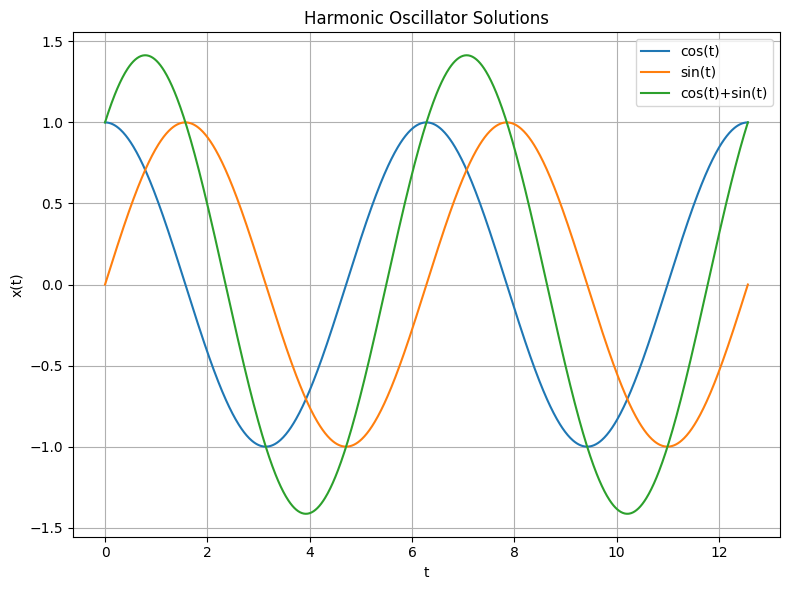

In [5]:
# Plot harmonic oscillator solutions
t_plot = Symbol('t', real=True)
omega_plot = Symbol('omega', positive=True)

# Different initial conditions
x1 = Cos(t_plot)  # x(0)=1, v(0)=0
x2 = Sin(t_plot)  # x(0)=0, v(0)=1
x3 = Cos(t_plot) + Sin(t_plot)  # Superposition

Plot(
    [x1, x2, x3],
    (t_plot, 0, 4 * 3.14159),
    PlotLabel="Harmonic Oscillator Solutions",
    AxesLabel=["t", "x(t)"],
    PlotLegends=["cos(t)", "sin(t)", "cos(t)+sin(t)"],
    GridLines=True,
)

## 2. The Simple Pendulum

For a pendulum of length $\ell$:

$$L = \frac{1}{2}m\ell^2\dot{\theta}^2 + mg\ell\cos\theta$$

The equation of motion is nonlinear: $\ddot{\theta} + \frac{g}{\ell}\sin\theta = 0$

### Small-Angle Approximation via Series

In [6]:
ell = Symbol('ell', positive=True)
theta = Function('theta')(t)
theta_dot = D(theta, t)

# Pendulum Lagrangian
T_pend = R(1, 2) * m * ell**2 * theta_dot**2
V_pend = -m * g * ell * Cos(theta)
L_pend = T_pend - V_pend

# Equation of motion
eq_pend = Simplify(EulerLagrangeEquation(L_pend, theta, [t]))
eq_pend

-ell*m*(ell*Derivative(theta(t), (t, 2)) + g*Sin(theta(t)))

In [7]:
# Small-angle approximation: sin(theta) ≈ theta - theta^3/6 + ...
theta_small = Symbol('theta', real=True)

sin_expansion = Series(Sin(theta_small), (theta_small, 0, 5))
sin_expansion

theta - theta**3/6 + theta**5/120 + O(theta**6)

The series shows $\sin\theta \approx \theta - \frac{\theta^3}{6} + O(\theta^5)$.

For small angles, the pendulum becomes a harmonic oscillator with $\omega = \sqrt{g/\ell}$.

### Numerical Solution with NDSolve

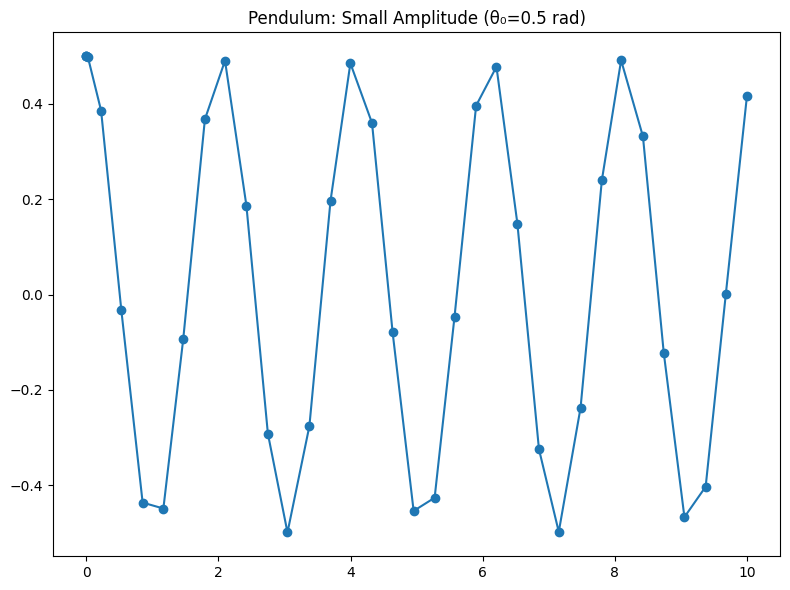

In [8]:
import numpy as np

# Pendulum ODE: theta'' + (g/l)*sin(theta) = 0
# As first-order system: y = [theta, omega]
# y' = [omega, -(g/l)*sin(theta)]

g_val = 9.8
ell_val = 1.0

def pendulum_ode(t_val, y):
    theta_val, omega_val = y
    return [omega_val, -(g_val/ell_val) * np.sin(theta_val)]

# Solve for initial angle = 0.5 rad
sol_small = NDSolve(pendulum_ode, [0.5, 0], (t, 0, 10))

# Solve for initial angle = 2.5 rad (large amplitude)
sol_large = NDSolve(pendulum_ode, [2.5, 0], (t, 0, 10))

# Plot comparison (single dataset)
small_data = list(zip(sol_small.t.tolist(), sol_small.y[0].tolist()))

ListLinePlot(
    small_data,
    PlotLabel="Pendulum: Small Amplitude (θ₀=0.5 rad)",
    AxesLabel=["t", "θ(t)"],
    GridLines=True,
)

The large-amplitude solution is **anharmonic** - notice the period is longer
and the shape is not a pure sinusoid.

## 3. Coupled Oscillators and Normal Modes

Two identical masses coupled by springs demonstrate **normal modes**.

The eigenvalues of the dynamical matrix give the squared frequencies $\omega^2$.

In [9]:
# Two coupled oscillators
k1, k2, k_c = symbols('k_1 k_2 k_c', positive=True)
x1_c = Function('x_1')(t)
x2_c = Function('x_2')(t)
v1_c = D(x1_c, t)
v2_c = D(x2_c, t)

# Lagrangian
T_coupled = R(1, 2) * m * (v1_c**2 + v2_c**2)
V_coupled = (R(1, 2) * k1 * x1_c**2 +
             R(1, 2) * k2 * x2_c**2 +
             R(1, 2) * k_c * (x2_c - x1_c)**2)
L_coupled = T_coupled - V_coupled

# Equations of motion
eq1 = Simplify(EulerLagrangeEquation(L_coupled, x1_c, [t]))
eq2 = Simplify(EulerLagrangeEquation(L_coupled, x2_c, [t]))
display(eq1, eq2)

-k_1*x_1(t) - k_c*(x_1(t) - x_2(t)) - m*Derivative(x_1(t), (t, 2))

-k_2*x_2(t) + k_c*(x_1(t) - x_2(t)) - m*Derivative(x_2(t), (t, 2))

In [10]:
# For identical springs (k1 = k2 = k), find normal mode frequencies
k_sym = Symbol('k', positive=True)
k_coupling = Symbol('k_c', positive=True)
m_sym = Symbol('m', positive=True)

# Dynamical matrix (from -d²x/dt² = A·x)
# With V = (1/2)k(x1² + x2²) + (1/2)k_c(x2-x1)²
# A = [[k + k_c, -k_c], [-k_c, k + k_c]] / m
A_matrix = Matrix([
    [k_sym + k_coupling, -k_coupling],
    [-k_coupling, k_sym + k_coupling]
]) / m_sym

# Eigenvalues are ω²
omega_squared = Eigenvalues(A_matrix)
omega_squared

{k/m: 1, (k + 2*k_c)/m: 1}

The normal modes are:
- **Symmetric mode**: $\omega_1^2 = k/m$ (masses move together)
- **Antisymmetric mode**: $\omega_2^2 = (k + 2k_c)/m$ (masses move opposite)

## 4. The Hamiltonian Formalism

The Hamiltonian is the Legendre transform of the Lagrangian:

$$H = \sum_i p_i \dot{q}_i - L$$

Hamilton's equations are:
$$\dot{q}_i = \frac{\partial H}{\partial p_i}, \quad \dot{p}_i = -\frac{\partial H}{\partial q_i}$$

In [11]:
# Harmonic oscillator in Hamiltonian form
x_h = Symbol('x', real=True)
p_h = Symbol('p', real=True)

# Hamiltonian: H = p²/(2m) + kx²/2
H_SHO = p_h**2 / (2*m) + R(1, 2) * k * x_h**2

# Hamilton's equations
x_dot = D(H_SHO, p_h)  # dx/dt = ∂H/∂p = p/m
p_dot = -D(H_SHO, x_h)  # dp/dt = -∂H/∂x = -kx

display(H_SHO, x_dot, p_dot)

k*x**2/2 + p**2/(2*m)

p/m

-k*x

### Phase Space Portrait

In phase space $(x, p)$, trajectories are curves of constant energy.
For the harmonic oscillator, these are ellipses.

<lambdifygenerated-4>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(1.0 - x**2)
<lambdifygenerated-5>:2: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(2.0 - x**2)


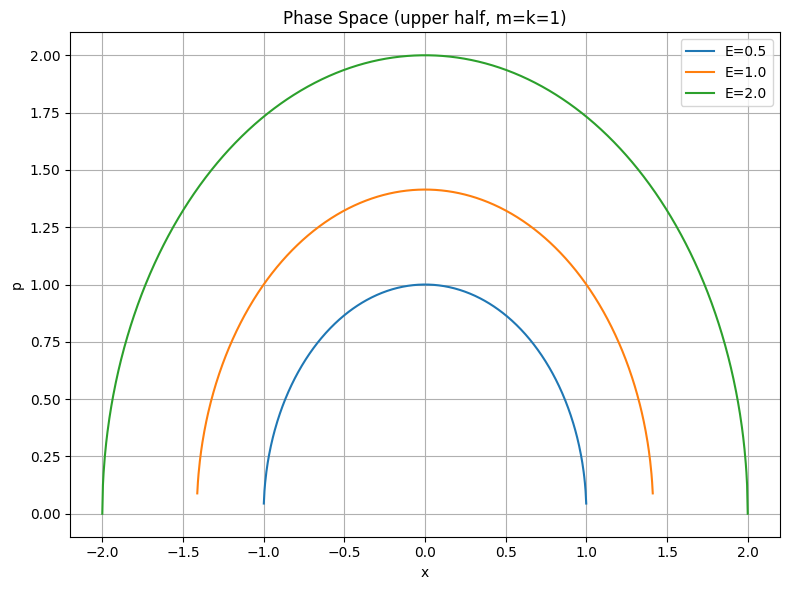

In [12]:
# Phase space trajectories (parametric plot would be ideal)
# x(t) = A*cos(ωt), p(t) = -mωA*sin(ωt)
# Eliminating t: (x/A)² + (p/(mωA))² = 1 (ellipse)

# Plot energy contours: H = p²/2 + x²/2 = E (with m=k=1)
x_phase = Symbol('x', real=True)

# p as function of x at constant E
E_vals = [0.5, 1.0, 2.0]

# Plot upper branches: p = sqrt(2E - x²)
p_1 = Sqrt(2*0.5 - x_phase**2)
p_2 = Sqrt(2*1.0 - x_phase**2)
p_3 = Sqrt(2*2.0 - x_phase**2)

Plot(
    [p_1, p_2, p_3],
    (x_phase, -2, 2),
    PlotLabel="Phase Space (upper half, m=k=1)",
    AxesLabel=["x", "p"],
    PlotLegends=["E=0.5", "E=1.0", "E=2.0"],
    GridLines=True,
)

## 5. Noether's Theorem

Every continuous symmetry of the Lagrangian corresponds to a conserved quantity.

| Symmetry | Conserved Quantity |
|----------|-------------------|
| Time translation | Energy |
| Space translation | Linear momentum |
| Rotation | Angular momentum |

In [13]:
# Central force in polar coordinates
r_c = Function('r')(t)
phi_c = Function('phi')(t)
r_dot = D(r_c, t)
phi_dot = D(phi_c, t)

# Kinetic energy in polar coordinates
T_central = R(1, 2) * m * (r_dot**2 + r_c**2 * phi_dot**2)

# Generic central potential V(r)
V_r = Function('V')(r_c)

L_central = T_central - V_r

# Angular momentum: p_phi = ∂L/∂(phi_dot) = m*r²*phi_dot
p_phi = D(L_central, phi_dot)
p_phi

m*r(t)**2*Derivative(phi(t), t)

Since $\frac{\partial L}{\partial \phi} = 0$ (rotational symmetry),
angular momentum $p_\phi = mr^2\dot{\phi}$ is conserved.

## 6. Discrete Dynamics: The Standard Map

The **standard map** (Chirikov map) is a model of chaos:

$$p_{n+1} = p_n + K \sin(\theta_n)$$

$$\theta_{n+1} = \theta_n + p_{n+1}$$

We use **NestList** to iterate this map.

In [14]:
# Standard map with chaos parameter K
K = 0.9  # Below critical value

def standard_map(state):
    theta, p = state
    p_new = p + K * np.sin(theta)
    theta_new = (theta + p_new) % (2 * np.pi)
    return (theta_new, p_new % (2 * np.pi))

# Iterate from initial condition
trajectory = NestList(standard_map, (1.0, 0.5), 1000)

# Extract for plotting
theta_vals = [s[0] for s in trajectory]
p_vals = [s[1] for s in trajectory]

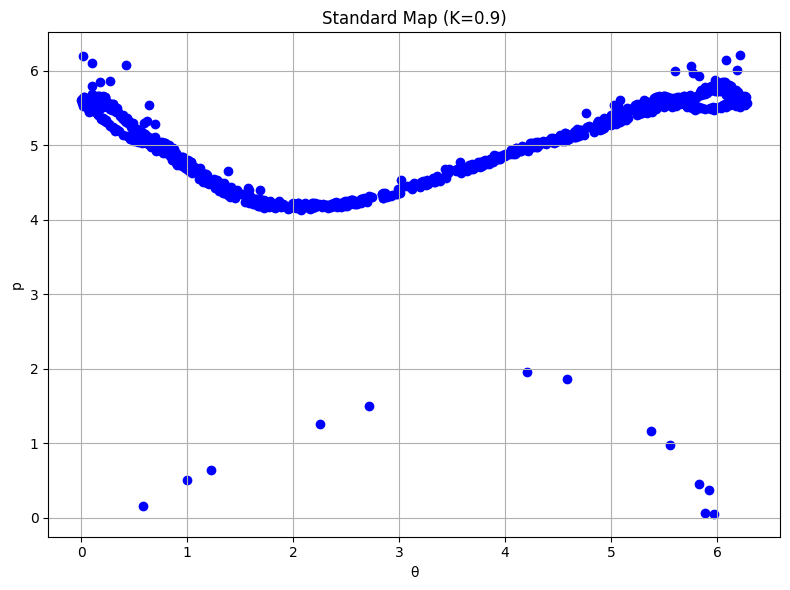

In [15]:
# Phase space portrait (Poincaré section)
poincare_data = list(zip(theta_vals, p_vals))

ListPlot(
    poincare_data,
    PlotLabel="Standard Map (K=0.9)",
    AxesLabel=["θ", "p"],
    PlotStyle="Blue",
    GridLines=True,
)

The trajectory shows **quasi-periodic** motion (for K < 1).
Above the critical value K ≈ 0.97, the map becomes chaotic.

## 7. The Kepler Problem

For a gravitational potential $V(r) = -GMm/r$, trajectories are conic sections.

The effective potential method reduces the 2D problem to 1D.

In [16]:
# Effective potential for Kepler problem
r_eff = Symbol('r', positive=True)
L_ang = Symbol('L', positive=True)  # Angular momentum
m_kepler = Symbol('m', positive=True)
GM = Symbol('GM', positive=True)

# V_eff = L²/(2mr²) - GMm/r
V_eff = L_ang**2 / (2 * m_kepler * r_eff**2) - GM * m_kepler / r_eff

V_eff

-GM*m/r + L**2/(2*m*r**2)

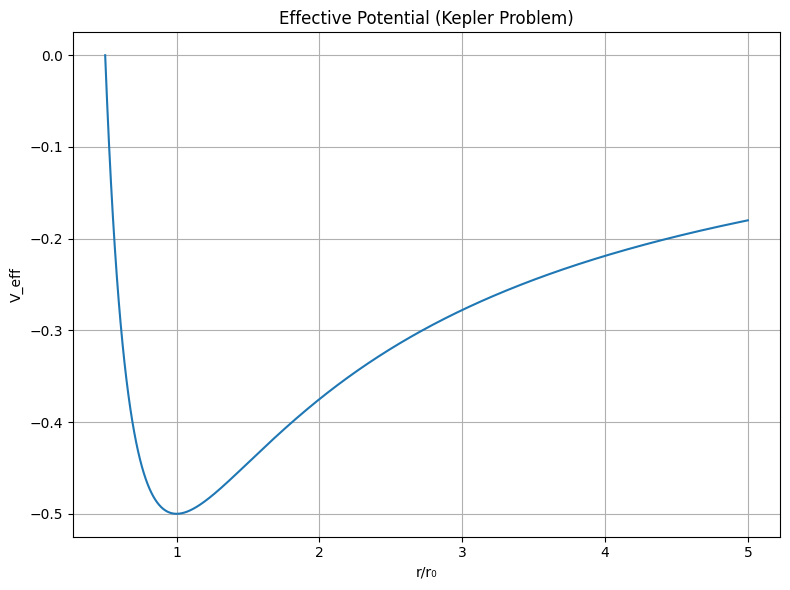

In [17]:
# Plot effective potential (dimensionless)
r_plot = Symbol('r', positive=True)

# V_eff / (GMm/r_0) where r_0 = L²/(GMm²)
# In these units: V_eff = 1/(2r²) - 1/r
V_eff_plot = R(1, 2) / r_plot**2 - 1 / r_plot

Plot(
    V_eff_plot,
    (r_plot, 0.5, 5),
    PlotLabel="Effective Potential (Kepler Problem)",
    AxesLabel=["r/r₀", "V_eff"],
    GridLines=True,
)

The minimum of the effective potential gives the circular orbit radius.
Bound orbits (E < 0) oscillate between turning points.

## Summary

We demonstrated symderive's classical mechanics capabilities:

| Feature | Usage |
|---------|-------|
| **EulerLagrangeEquation** | Derive equations of motion |
| **DSolve** | Analytical solutions (harmonic oscillator) |
| **NDSolve** | Numerical trajectories (pendulum) |
| **Eigenvalues** | Normal mode frequencies |
| **Series** | Small-angle approximations |
| **Plot** | Phase portraits, potentials |
| **NestList** | Discrete maps (standard map) |
| **D** | Hamiltonian equations |

symderive provides comprehensive tools for analytical mechanics!